In [1]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
!unzip speech-emotion-recognition-en.zip

"kaggle" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split
from torchaudio.transforms import MelSpectrogram, Spectrogram, AmplitudeToDB
import tqdm
from tqdm.auto import tqdm

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3060


In [81]:
root_dir = 'C:/Users/Ksenia/Desktop/6_2'

crema_path = root_dir + "/Crema/"
ravdess_path = root_dir + "/Ravdess/audio_speech_actors_01-24/"
savee_path = root_dir + "/Savee/"
tess_path = root_dir + "/Tess/"

In [82]:
crema_dir_list = os.listdir(crema_path)
ravdess_dir_list = os.listdir(ravdess_path)
savee_dir_list = os.listdir(savee_path)
tess_dir_list = os.listdir(tess_path)

In [83]:
emotions_crema = []
paths_crema = []

for it in crema_dir_list:
    paths_crema.append(crema_path + it)

    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')


emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])

path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)
print(crema_df.shape)

(7442, 2)


In [84]:
emotions_ravdess = []
path_ravdess = []

for it in ravdess_dir_list:
    actor = os.listdir(ravdess_path + it)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')

        emotions_ravdess.append(int(part[2]))
        path_ravdess.append(ravdess_path + it + '/' + file)


emotion_ravdess_df = pd.DataFrame(emotions_ravdess, columns=['Emotions'])

path_ravdess_df = pd.DataFrame(path_ravdess, columns=['Path'])
ravdess_df = pd.concat([emotion_ravdess_df, path_ravdess_df], axis=1)

# вместо цифр - эмоции
ravdess_df.Emotions.replace({1:'neutral', 2:'calm',
                             3:'happy', 4:'sad', 5:'angry',
                             6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

In [85]:
emotions_savee = []
path_savee = []

for it in savee_dir_list:
    path_savee.append(savee_path + it)
    part = it.split('_')[1]
    part = part[:-6]
    if part == 'a':
        emotions_savee.append('angry')
    elif part == 'd':
        emotions_savee.append('disgust')
    elif part == 'f':
        emotions_savee.append('fear')
    elif part == 'h':
        emotions_savee.append('happiness')
    elif part == 'n':
        emotions_savee.append('neutral')
    elif part == 'sa':
        emotions_savee.append('sadness')
    elif part == 'su':
        emotions_savee.append('surprise')

    else:
        emotions_savee.append('Unknown')

emotion_savee_df = pd.DataFrame(emotions_savee, columns=['Emotions'])

path_savee_df = pd.DataFrame(path_savee, columns=['Path'])
savee_df = pd.concat([emotion_savee_df, path_savee_df], axis=1)

In [86]:
emotions_tess = []
path_tess = []

for it in tess_dir_list:
    directories = os.listdir(tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(tess_path + it + '/' + file)



emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])

path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)

In [87]:
sum_df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
sum_df.to_csv("Sum_df.csv", index=False)

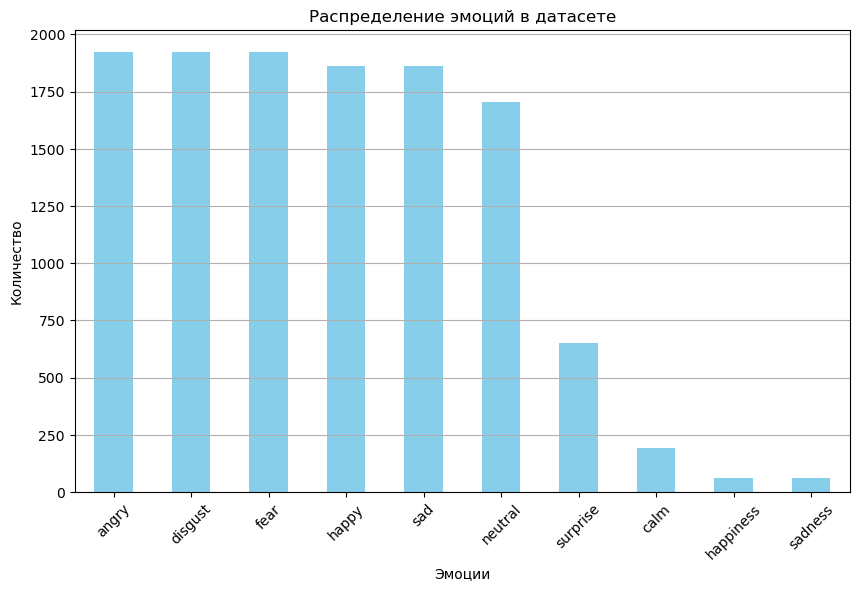

In [88]:
emotion_counts = sum_df['Emotions'].value_counts()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение эмоций в датасете')
plt.xlabel('Эмоции')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

In [79]:
# Happiness, sadness и calm это то же, что и happy, sad и neutral. Переименую их.
sum_df_rep = sum_df
sum_df_rep['Emotions'].replace('happiness', 'happy', inplace=True)
sum_df_rep['Emotions'].replace('sadness', 'sad', inplace=True)
sum_df_rep['Emotions'].replace('calm', 'neutral', inplace=True)

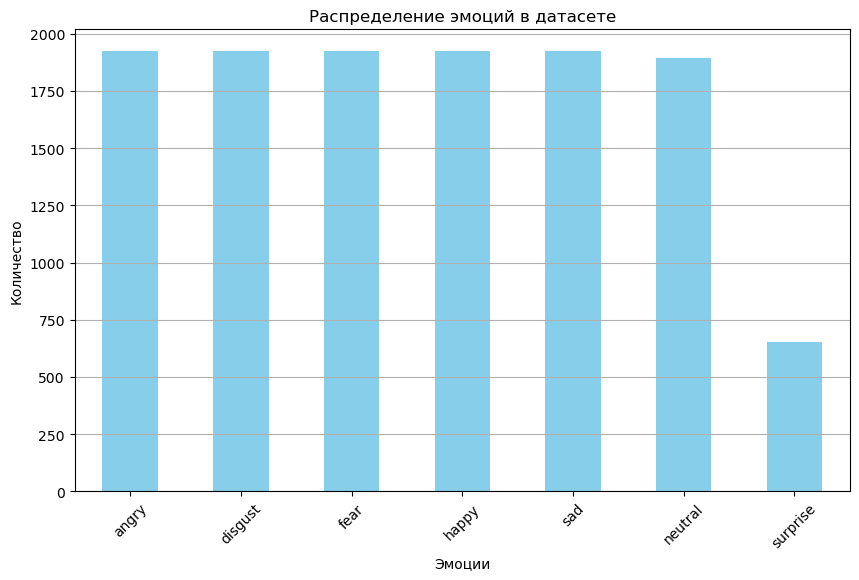

In [78]:
emotion_counts = sum_df['Emotions'].value_counts()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение эмоций в датасете')
plt.xlabel('Эмоции')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

In [11]:
sum_df_rep

,Emotions,Path
0,angry,C:/Users/Ksenia/Desktop/6_2/Crema/1001_DFA_ANG...
1,disgust,C:/Users/Ksenia/Desktop/6_2/Crema/1001_DFA_DIS...
2,fear,C:/Users/Ksenia/Desktop/6_2/Crema/1001_DFA_FEA...
3,happy,C:/Users/Ksenia/Desktop/6_2/Crema/1001_DFA_HAP...
4,neutral,C:/Users/Ksenia/Desktop/6_2/Crema/1001_DFA_NEU...
...,...,...
2795,sad,C:/Users/Ksenia/Desktop/6_2/Tess/YAF_sad/YAF_w...
2796,sad,C:/Users/Ksenia/Desktop/6_2/Tess/YAF_sad/YAF_y...
2797,sad,C:/Users/Ksenia/Desktop/6_2/Tess/YAF_sad/YAF_y...
2798,sad,C:/Users/Ksenia/Desktop/6_2/Tess/YAF_sad/YAF_y...


In [53]:
labels_crema = crema_df['Emotions'].to_list()
audio_path_test_crema = crema_df['Path'].to_list()

audio_path_crema = []
file_names_crema = []

for path in crema_df['Path']:
    directory = os.path.dirname(path)
    file_name = os.path.basename(path)

    audio_path_crema.append(directory)
    file_names_crema.append(file_name)

len(audio_path_test_crema), len(file_names_crema), len(labels_crema)

(7442, 7442, 7442)

In [54]:
labels = sum_df_rep['Emotions'].to_list()

audio_path_test = sum_df_rep['Path'].to_list()
audio_path = []
file_names = []

for path in sum_df_rep['Path']:
    directory = os.path.dirname(path)
    file_name = os.path.basename(path)

    audio_path.append(directory)
    file_names.append(file_name)

len(audio_path), len(file_names), len(labels)

(12162, 12162, 12162)

In [55]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded_crema = label_encoder.fit_transform(labels_crema)

In [56]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [57]:
class AudioDataset(Dataset):
    def __init__(self, full_path, labels, transforms=None, num_samples=16000):
        super().__init__()
        self.full_path = full_path
        self.num_samples = num_samples
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        path = self.full_path[index]
        signal, sr = torchaudio.load(path)
        signal = self.mix_down_if_necessary(signal)
        signal = self.cut_if_necessary(signal)
        signal = self.right_pad_if_necessary(signal)
        if self.transforms:
            signal = self.transforms(signal)
        else:
            signal = self.get_pitch_spectrogram(signal)
        label = (self.labels[index])
        return signal, label

    def __len__(self):
        return len(self.labels)

    def mix_down_if_necessary(self, signal): #converting from stereo to mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim = 0, keepdims = True)
        return signal

    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, self.num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

    def get_pitch_spectrogram(self, signal):
        stft = torch.stft(signal.squeeze(0), n_fft=2048, hop_length=512, window=torch.hann_window(2048), return_complex=True)
        magnitude = torch.abs(stft)
        pitch_spectrogram = torch.log1p(magnitude)
        return pitch_spectrogram

In [58]:
file_paths_train_crema, file_paths_test_crema, labels_train_crema, labels_test_crema = train_test_split(
    audio_path_test_crema, labels_encoded_crema, test_size=0.2, random_state=42, stratify=labels_encoded_crema
)

In [59]:
file_paths_train, file_paths_test, labels_train, labels_test = train_test_split(
    audio_path_test, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

In [60]:
class EmotionCNN(nn.Module):
    def __init__(self, pitch=False, mfcc=False, spec=False):
        super(EmotionCNN, self).__init__()
        self.pitch = pitch
        self.mfcc = mfcc
        self.spec = spec
        
        if self.pitch:
            self.fc1 = nn.Linear(128 * 128 * 4, 128)
        elif self.mfcc:
            self.fc1 = nn.Linear(128 * 1 * 10, 128)
        elif self.spec:
            self.fc1 = nn.Linear(128 * 25 * 10, 128)
        else:
            self.fc1 = nn.Linear(128 * 16 * 10, 128)
        
        self.conv1 = nn.Conv2d(1, 512, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
# Backup модель, сначала пробовала её
class EmotionCNN2(nn.Module):
    def __init__(self, pitch=False):
        super(EmotionCNN2, self).__init__()
        self.pitch = pitch
        if self.pitch:
            self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(32 * 256 * 8, 128)
        else:
            self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(32 * 32 * 20, 128)

        self.do1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.do2 = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(1)
        x = self.pool(F.relu(self.do1(self.conv1(x))))
        x = self.pool(F.relu(self.do2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [62]:
def train_model(model, criterion, optimizer, loaders, max_epochs=10):
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        epoch_loss = []
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    epoch_loss.append(loss.item())
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}. Train loss: {np.mean(epoch_loss)}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [63]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [64]:
# Только Crema
train_dataset_mfcc_crema = AudioDataset(file_paths_train_crema, labels_train_crema, T.MFCC(sample_rate=16000, n_mfcc=13))
test_dataset_mfcc_crema = AudioDataset(file_paths_test_crema, labels_test_crema, T.MFCC(sample_rate=16000, n_mfcc=13))

train_loader_mfcc_crema = DataLoader(train_dataset_mfcc_crema, batch_size=32, shuffle=True)
test_loader_mfcc_crema = DataLoader(test_dataset_mfcc_crema, batch_size=32, shuffle=False)

C:\Users\Ksenia\anaconda3\envs\new-env\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [65]:
# Все, MFCC
train_dataset_mfcc = AudioDataset(file_paths_train, labels_train, T.MFCC(sample_rate=16000, n_mfcc=13))
test_dataset_mfcc = AudioDataset(file_paths_test, labels_test, T.MFCC(sample_rate=16000, n_mfcc=13))

train_loader_mfcc = DataLoader(train_dataset_mfcc, batch_size=32, shuffle=True)
test_loader_mfcc = DataLoader(test_dataset_mfcc, batch_size=32, shuffle=False)

In [66]:
# Все, Pitch
train_dataset_pitch = AudioDataset(file_paths_train, labels_train)
test_dataset_pitch = AudioDataset(file_paths_test, labels_test)

train_loader_pitch = DataLoader(train_dataset_pitch, batch_size=32, shuffle=True)
test_loader_pitch = DataLoader(test_dataset_pitch, batch_size=32, shuffle=False)

In [67]:
# Все, Spectrogram
train_dataset_spec = AudioDataset(file_paths_train, labels_train, Spectrogram())
test_dataset_spec = AudioDataset(file_paths_test, labels_test, Spectrogram())

train_loader_spec = DataLoader(train_dataset_spec, batch_size=32, shuffle=True)
test_loader_spec = DataLoader(test_dataset_spec, batch_size=32, shuffle=False)

In [68]:
# Все, Mel Spectrogram
train_dataset_mel = AudioDataset(file_paths_train, labels_train, transforms=MelSpectrogram())
test_dataset_mel = AudioDataset(file_paths_test, labels_test, transforms=MelSpectrogram())

train_loader_mel = DataLoader(train_dataset_mel, batch_size=128, shuffle=True)
test_loader_mel = DataLoader(test_dataset_mel, batch_size=128, shuffle=False)

In [69]:
# Только Crema
model_crema = EmotionCNN(mfcc=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_crema.parameters(), lr=0.001)
loaders_crema = {"train": test_loader_mfcc_crema, "valid": test_loader_mfcc_crema}

In [26]:
# Только Crema
train_model(model_crema, criterion, optimizer, loaders_crema, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.2793821356615178. Train loss: 1.7097006326026105
Loader: valid. Accuracy: 0.3310946944257891. Train loss: 1.7097006326026105
Epoch: 2
Loader: train. Accuracy: 0.3169912693082606. Train loss: 1.5960507747974801
Loader: valid. Accuracy: 0.3519140362659503. Train loss: 1.5960507747974801
Epoch: 3
Loader: train. Accuracy: 0.3351242444593687. Train loss: 1.5680110099467826
Loader: valid. Accuracy: 0.3794492948287441. Train loss: 1.5680110099467826
Epoch: 4
Loader: train. Accuracy: 0.35661517797179315. Train loss: 1.5418863600872932
Loader: valid. Accuracy: 0.3687038280725319. Train loss: 1.5418863600872932
Epoch: 5
Loader: train. Accuracy: 0.36803223640026866. Train loss: 1.5197265122799164
Loader: valid. Accuracy: 0.3948959032907992. Train loss: 1.5197265122799164
Epoch: 6
Loader: train. Accuracy: 0.38079247817327067. Train loss: 1.4916948511245403
Loader: valid. Accuracy: 0.40698455339153794. Train loss: 1.4916948511245403
Epoch: 7
Loader: train. Accura

[0.3310946944257891,
 0.3519140362659503,
 0.3794492948287441,
 0.3687038280725319,
 0.3948959032907992,
 0.40698455339153794,
 0.41638683680322364,
 0.4304902619207522,
 0.41571524513096036,
 0.4519811954331766,
 0.49697783747481533,
 0.5184687709872398,
 0.5312290127602418,
 0.539288112827401,
 0.5782404298186703,
 0.5708529214237743,
 0.4519811954331766,
 0.5594358629952989,
 0.6836803223640027,
 0.7454667562122229,
 0.7468099395567495,
 0.3834788448623237,
 0.374076561450638,
 0.738079247817327,
 0.7320349227669577,
 0.664204163868368,
 0.49429147078576224,
 0.9147078576225655,
 0.8629952988582942,
 0.8441907320349228]

In [32]:
# Все, Mel Spectrogram
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loaders_mel = {"train": train_loader_mel, "valid": test_loader_mel}

In [29]:
train_model(model, criterion, optimizer, loaders_mel, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.2974611984787748. Train loss: 1.760731276753661
Loader: valid. Accuracy: 0.3197698314837649. Train loss: 1.760731276753661
Epoch: 2
Loader: train. Accuracy: 0.3561517113783534. Train loss: 1.6249124771588808
Loader: valid. Accuracy: 0.3242909987669544. Train loss: 1.6249124771588808
Epoch: 3
Loader: train. Accuracy: 0.3625244115530887. Train loss: 1.5986674697638803
Loader: valid. Accuracy: 0.40731607069461573. Train loss: 1.5986674697638803
Epoch: 4
Loader: train. Accuracy: 0.43118511666152737. Train loss: 1.44241738938666
Loader: valid. Accuracy: 0.42827784628031235. Train loss: 1.44241738938666
Epoch: 5
Loader: train. Accuracy: 0.4410525233836982. Train loss: 1.3571433896658482
Loader: valid. Accuracy: 0.36621454993834773. Train loss: 1.3571433896658482
Epoch: 6
Loader: train. Accuracy: 0.48740877788056325. Train loss: 1.268273685659681
Loader: valid. Accuracy: 0.30004110152075625. Train loss: 1.268273685659681
Epoch: 7
Loader: train. Accuracy: 0.

[0.3197698314837649,
 0.3242909987669544,
 0.40731607069461573,
 0.42827784628031235,
 0.36621454993834773,
 0.30004110152075625,
 0.3242909987669544,
 0.3937525688450473,
 0.32305795314426633,
 0.32552404438964244,
 0.35511713933415534,
 0.32346896835182903,
 0.2942868886148787,
 0.3177147554459515,
 0.25359638306617344,
 0.2934648581997534,
 0.3296341964652692,
 0.3362104397862721,
 0.3333333333333333,
 0.3210028771064529]

In [33]:
# Все, Pitch
model2 = EmotionCNN(pitch=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
loaders_pitch = {"train": train_loader_pitch, "valid": test_loader_pitch}

In [26]:
train_model(model2, criterion, optimizer, loaders_pitch, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.3686915407544455. Train loss: 1.8589059958692458
Loader: valid. Accuracy: 0.42868886148787505. Train loss: 1.8589059958692458
Epoch: 2
Loader: train. Accuracy: 0.4551341350601295. Train loss: 1.3253776483848447
Loader: valid. Accuracy: 0.4829428688861488. Train loss: 1.3253776483848447
Epoch: 3
Loader: train. Accuracy: 0.48401685681981704. Train loss: 1.254657678525956
Loader: valid. Accuracy: 0.46937936703658034. Train loss: 1.254657678525956
Epoch: 4
Loader: train. Accuracy: 0.4954260458423271. Train loss: 1.2155879937135232
Loader: valid. Accuracy: 0.4928072338676531. Train loss: 1.2155879937135232
Epoch: 5
Loader: train. Accuracy: 0.5059101654846335. Train loss: 1.2046754895663652
Loader: valid. Accuracy: 0.5026715988491575. Train loss: 1.2046754895663652
Epoch: 6
Loader: train. Accuracy: 0.5161887141535615. Train loss: 1.1828157018442622
Loader: valid. Accuracy: 0.49157418824496507. Train loss: 1.1828157018442622
Epoch: 7
Loader: train. Accuracy

[0.42868886148787505,
 0.4829428688861488,
 0.46937936703658034,
 0.4928072338676531,
 0.5026715988491575,
 0.49157418824496507,
 0.5137690094533498,
 0.5039046444718455,
 0.49856144677353065,
 0.5154130702836005,
 0.5145910398684751,
 0.5141800246609125,
 0.5006165228113441,
 0.5080147965474723,
 0.5207562679819153,
 0.5154130702836005,
 0.5080147965474723,
 0.5137690094533498,
 0.5080147965474723,
 0.5080147965474723]

In [70]:
# Все, MFCC
model3 = EmotionCNN(mfcc=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)
loaders_mfcc = {"train": train_loader_mfcc, "valid": test_loader_mfcc}

In [71]:
train_model(model3, criterion, optimizer, loaders_mfcc, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.3185322232500771. Train loss: 1.6274666113931624
Loader: valid. Accuracy: 0.427455815865187. Train loss: 1.6274666113931624
Epoch: 2
Loader: train. Accuracy: 0.4550313495734402. Train loss: 1.3260840396412084
Loader: valid. Accuracy: 0.4923962186600904. Train loss: 1.3260840396412084
Epoch: 3
Loader: train. Accuracy: 0.49809846849624834. Train loss: 1.2360530782918462
Loader: valid. Accuracy: 0.48540896013152485. Train loss: 1.2360530782918462
Epoch: 4
Loader: train. Accuracy: 0.5099187994655154. Train loss: 1.2001902128829331
Loader: valid. Accuracy: 0.5260994656802301. Train loss: 1.2001902128829331
Epoch: 5
Loader: train. Accuracy: 0.5268784047692466. Train loss: 1.1520245837383583
Loader: valid. Accuracy: 0.5219893136046033. Train loss: 1.1520245837383583
Epoch: 6
Loader: train. Accuracy: 0.5363346695446602. Train loss: 1.136622824043524
Loader: valid. Accuracy: 0.5425400739827374. Train loss: 1.136622824043524
Epoch: 7
Loader: train. Accuracy: 0

[0.427455815865187,
 0.4923962186600904,
 0.48540896013152485,
 0.5260994656802301,
 0.5219893136046033,
 0.5425400739827374,
 0.5367858610768599,
 0.5310316481709824,
 0.5150020550760378,
 0.5474722564734895,
 0.5466502260583641,
 0.4615700780928894,
 0.5376078914919852,
 0.5425400739827374,
 0.5602137279079326,
 0.5536374845869297,
 0.5367858610768599,
 0.5589806822852446,
 0.5499383477188656,
 0.553226469379367,
 0.5380189066995479,
 0.551993423756679,
 0.5339087546239211,
 0.5450061652281134,
 0.5293875873407317,
 0.5339087546239211,
 0.5384299219071106,
 0.5351418002466092,
 0.5433621043978627,
 0.5408960131524866,
 0.5487053020961775,
 0.5380189066995479,
 0.5154130702836005,
 0.5515824085491163,
 0.5281545417180435,
 0.5441841348129881,
 0.5351418002466092,
 0.5413070283600493,
 0.5433621043978627,
 0.5367858610768599,
 0.5359638306617345,
 0.5141800246609125,
 0.5326757090012331,
 0.5367858610768599,
 0.5478832716810522,
 0.522400328812166,
 0.5228113440197287,
 0.5187011919441

In [35]:
# Все, Spectrogram
model4 = EmotionCNN(spec=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loaders_spec = {"train": train_loader_spec, "valid": test_loader_spec}

In [44]:
train_model(model4, criterion, optimizer, loaders_spec, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.29067735635728237. Train loss: 1.7640104848830427
Loader: valid. Accuracy: 0.3099054665022606. Train loss: 1.7640104848830427
Epoch: 2
Loader: train. Accuracy: 0.33970603350806866. Train loss: 1.6387355061828113
Loader: valid. Accuracy: 0.2766132346896835. Train loss: 1.6387355061828113
Epoch: 3
Loader: train. Accuracy: 0.409702949943468. Train loss: 1.4620269196932434
Loader: valid. Accuracy: 0.3053842992190711. Train loss: 1.4620269196932434
Epoch: 4
Loader: train. Accuracy: 0.4565731318737794. Train loss: 1.3511302296782188
Loader: valid. Accuracy: 0.1890669954788327. Train loss: 1.3511302296782188
Epoch: 5
Loader: train. Accuracy: 0.4791859389454209. Train loss: 1.278548741865842
Loader: valid. Accuracy: 0.20057542129058775. Train loss: 1.278548741865842
Epoch: 6
Loader: train. Accuracy: 0.4923424812416487. Train loss: 1.2371215600188303
Loader: valid. Accuracy: 0.19687628442252364. Train loss: 1.2371215600188303
Epoch: 7
Loader: train. Accuracy:

[0.3099054665022606,
 0.2766132346896835,
 0.3053842992190711,
 0.1890669954788327,
 0.20057542129058775,
 0.19687628442252364,
 0.22359227291409783,
 0.23592272914097823,
 0.22523633374434854,
 0.16193999177969584,
 0.24989724619810932,
 0.22441430332922319,
 0.21085080147965474,
 0.22975750102753803,
 0.22277024249897245,
 0.18495684340320592,
 0.218249075215783,
 0.23551171393341552,
 0.21249486230990547,
 0.2342786683107275]

In [36]:
# Все, Mel Spectrogram, Backup модель
model_cnn2 = EmotionCNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.001)
loaders_mel = {"train": train_loader_mel, "valid": test_loader_mel}

In [28]:
train_model(model_cnn2, criterion, optimizer, loaders_mel, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.2649809846849625. Train loss: 2.1585683451070414
Loader: valid. Accuracy: 0.29017673653925197. Train loss: 2.1585683451070414
Epoch: 2
Loader: train. Accuracy: 0.35162914996402506. Train loss: 1.6069422317789746
Loader: valid. Accuracy: 0.3522400328812166. Train loss: 1.6069422317789746
Epoch: 3
Loader: train. Accuracy: 0.42070099701922087. Train loss: 1.5046735847151125
Loader: valid. Accuracy: 0.4319769831483765. Train loss: 1.5046735847151125
Epoch: 4
Loader: train. Accuracy: 0.45575084798026516. Train loss: 1.4119987394902613
Loader: valid. Accuracy: 0.43238799835593916. Train loss: 1.4119987394902613
Epoch: 5
Loader: train. Accuracy: 0.4767190872648782. Train loss: 1.3378593101129903
Loader: valid. Accuracy: 0.4508836826962598. Train loss: 1.3378593101129903
Epoch: 6
Loader: train. Accuracy: 0.5025182444238874. Train loss: 1.2440767675251156
Loader: valid. Accuracy: 0.4808877928483354. Train loss: 1.2440767675251156
Epoch: 7
Loader: train. Accur

[0.29017673653925197,
 0.3522400328812166,
 0.4319769831483765,
 0.43238799835593916,
 0.4508836826962598,
 0.4808877928483354,
 0.4845869297163995,
 0.4784217016029593,
 0.490341142622277,
 0.5051376900945335,
 0.4849979449239622,
 0.4763666255651459,
 0.4932182490752158,
 0.4936292642827785,
 0.48581997533908755,
 0.49815043156596794,
 0.47307850390464445,
 0.4886970817920263,
 0.4829428688861488,
 0.48910809699958896,
 0.49157418824496507,
 0.4928072338676531,
 0.4956843403205919,
 0.48540896013152485,
 0.4948623099054665,
 0.4825318536785861,
 0.46937936703658034,
 0.48746403616933826,
 0.4722564734895191,
 0.4545828195643239,
 0.4952733251130292,
 0.4739005343197698,
 0.48951911220715166,
 0.4739005343197698,
 0.4825318536785861,
 0.4833538840937115,
 0.48006576243321003,
 0.4849979449239622,
 0.49445129469790383,
 0.4923962186600904,
 0.4849979449239622,
 0.49116317303740237,
 0.48212083847102344,
 0.4886970817920263,
 0.47718865598027127,
 0.4833538840937115,
 0.4874640361693382

In [37]:
# Все, Pitch, Backup модель
model_cnn21 = EmotionCNN2(pitch=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn21.parameters(), lr=0.001)
loaders_pitch = {"train": train_loader_pitch, "valid": test_loader_pitch}

In [32]:
train_model(model_cnn21, criterion, optimizer, loaders_pitch, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.44033302497687327. Train loss: 1.4197358647330862
Loader: valid. Accuracy: 0.5166461159062885. Train loss: 1.4197358647330862
Epoch: 2
Loader: train. Accuracy: 0.5270839757426251. Train loss: 1.1711122104378997
Loader: valid. Accuracy: 0.5039046444718455. Train loss: 1.1711122104378997
Epoch: 3
Loader: train. Accuracy: 0.5859800596155823. Train loss: 1.0372979616364617
Loader: valid. Accuracy: 0.5195232223592273. Train loss: 1.0372979616364617
Epoch: 4
Loader: train. Accuracy: 0.6533045533970603. Train loss: 0.871144549670766
Loader: valid. Accuracy: 0.4969173859432799. Train loss: 0.871144549670766
Epoch: 5
Loader: train. Accuracy: 0.710556069482989. Train loss: 0.7339840446339279
Loader: valid. Accuracy: 0.4940402794903411. Train loss: 0.7339840446339279
Epoch: 6
Loader: train. Accuracy: 0.75177304964539. Train loss: 0.6249113789347351
Loader: valid. Accuracy: 0.4849979449239622. Train loss: 0.6249113789347351
Epoch: 7
Loader: train. Accuracy: 0.78

[0.5166461159062885,
 0.5039046444718455,
 0.5195232223592273,
 0.4969173859432799,
 0.4940402794903411,
 0.4849979449239622,
 0.4882860665844636,
 0.4862309905466502,
 0.490341142622277,
 0.48951911220715166,
 0.4849979449239622,
 0.49445129469790383,
 0.4948623099054665,
 0.4973284011508426,
 0.48951911220715166,
 0.48951911220715166,
 0.4932182490752158,
 0.49116317303740237,
 0.4919852034525277,
 0.490341142622277,
 0.4845869297163995,
 0.477599671187834,
 0.5014385532264694,
 0.49157418824496507,
 0.4907521578298397,
 0.4870530209617756,
 0.48910809699958896,
 0.4919852034525277,
 0.4870530209617756,
 0.4747225647348952,
 0.48746403616933826,
 0.4907521578298397,
 0.48417591450883685,
 0.4849979449239622,
 0.4722564734895191,
 0.490341142622277,
 0.4862309905466502,
 0.4812988080558981,
 0.48746403616933826,
 0.49157418824496507,
 0.48581997533908755,
 0.4845869297163995,
 0.48581997533908755,
 0.4866420057542129,
 0.48170982326346073,
 0.49157418824496507,
 0.4907521578298397,
 0

В итоге, лучше всего себя показали MFCC и Pitch